In [1]:
from time import time
import pickle
import os
import numpy as np
from adaptive.experiment import run_mab_experiment
from adaptive.compute import fill_up, collect
from adaptive.inference import aw_scores, sample_mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(font_scale=1.2)
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Introduction Example

DGP: run a contextual bandit experiment with a Thompson sampling agent, collecting $1000$ observations for one simulation.  
- context space $\{x_0, x_1, x_2, x_3, x_4\}$ with probability $[0.6, 0.1, 0.1, 0.1]$. 
- arms: $\{w_0, w_1, w_2, w_3, w_4\}$ 
- potential outcomes of $x_i$ assigned to $w_j$: $0.5\cdot\one_{i=j} + \mathcal{N}(0,1)$
- agent: Thompson sampling with floor $0.2t^{-0.7}$

Target policy: always assigning treatment $W_t=w_0$.

Compared estimators: Direct Method (DM) and Doubly Robust (DR).

In [2]:
K = 5  # number of arms
N = 5  # number of different context
initial = 2  # initial number of samples of each arm to do pure exploration
floor_start = 1/K
floor_decay = 0.7
noise_scale = 1.0
signal = 0.5
T = 1000

In [3]:
p_X = [0.6, 0.1, 0.1, 0.1, 0.1]
truth = np.eye(K) * signal
w_optimal_X = np.eye(K)
mu_K = np.transpose(truth).dot(p_X)

In [11]:
arm=0
sim = 1000
DM = []
AIPW = []

## Run simulations

In [12]:
Probs = []
for _ in range(sim):
    """ Generate data """
    xs = np.random.choice(a=N, size=T, p=p_X)
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=(T, K))
    #noise = np.random.uniform(-noise_scale, noise_scale, size=(T, K))
    #R = noise_scale * 2
    ys = truth[xs] + noise
    """ Run experiment """
    probs = np.zeros((T, N, K))
    rewards = np.zeros(T)
    arms = np.zeros(T, dtype=np.int)
    muhat = np.zeros((T, K))
    for n in range(N):
        idx = xs == n
        data = run_mab_experiment(
            ys[idx],
            initial=initial,
            floor_start=floor_start,
            floor_decay=floor_decay)
        P = data['probs']
        idx_a = np.where(xs == n)[0]
        if idx_a[-1] < T-1:
            idx_a = np.concatenate([idx_a, [T-1]])
            P = np.concatenate([P, [data['future_p']]], axis=0)
        probs[:, n, :] = fill_up(T, idx_a, P)
        rewards[idx] = data['rewards']
        arms[idx] = data['arms']
        muhat[idx] = sample_mean(rewards[idx], arms[idx], K)[-1]
    balwts = 1 / collect(probs[np.arange(T), xs], arms)
    scores = aw_scores(rewards, arms, balwts, K, muhat)
    # add best arm policy
    Probs.append(probs[:, :, arm])
    best_mtx = np.zeros((T, K))
    best_mtx[:, arm] = 1
    qx = truth[:, arm] * p_X
    DM.append(np.mean(np.sum(muhat * best_mtx, axis=1)))
    AIPW.append(np.mean(np.sum(scores * best_mtx, axis=1)))

/Users/rhzhan/opt/anaconda3/envs/aw_contextual/lib/python3.7/site-packages/ipykernel-5.4.3-py3.7.egg/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


## Boxplot of estimates of DM and DR

DM bias: -0.08363857099752572, std: 0.10461732973817818
AIPW bias: -0.026868419891486917, std: 0.15024634959752872


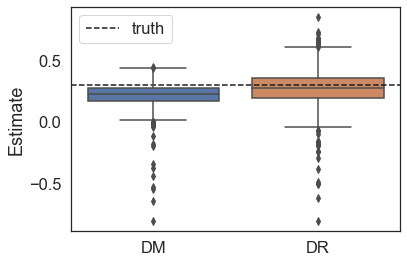

In [13]:
print(f"DM bias: {np.mean(DM) - mu_K[arm]}, std: {np.std(DM)}")
print(f"AIPW bias: {np.mean(AIPW) - mu_K[arm]}, std: {np.std(AIPW)}")
dataset_1 = pd.DataFrame({'method':['DM']*len(DM), 'eval': np.array(DM)})
dataset_2 = pd.DataFrame({'method':['DR']*len(AIPW), 'eval': np.array(AIPW)})
dataset = pd.concat([dataset_1, dataset_2])
sns.set(style='white', font_scale=1.5)
f, ax = plt.subplots()
ax.axhline(y=mu_K[arm], color='k', linestyle='--', label='truth')
sns.boxplot(x='method', y='eval', data=dataset)
ax.set_xlabel('')
ax.legend()
ax.set_ylabel('Estimate')
plt.tight_layout()

## Evolution of variance proxy over time with different covariates

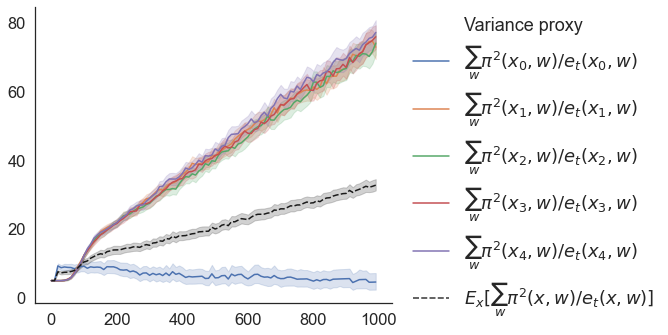

In [14]:
sns.set_context(font_scale=2)
cond_var = 1 / np.array(Probs)
idx = np.arange(0,T,T//100)
df = []
for i in range(K):
    df.append(pd.DataFrame({'$1/e_t$': np.concatenate(cond_var[:, idx, i], axis=0), 't': np.tile(idx, sim), 
                            'Value':[str(i)]*(len(idx)*sim), 'Style':[0]*(len(idx)*sim)}))
df.append(pd.DataFrame({'$1/e_t$': np.concatenate(cond_var[:, idx, :], axis=0).dot(p_X), 't': np.tile(idx, sim), 
                        'Value':['E']*(len(idx)*sim), 'Style':[1]*(len(idx)*sim)}))
df = pd.concat(df)
hue_order = [str(i) for i in range(K)]
hue_order.append('E')
g = sns.relplot(data=df, kind='line', x='t', y='$1/e_t$', hue='Value', 
                aspect=1.0, 
                hue_order=hue_order,
                palette=[*sns.color_palette()[:K], 'k'],
                style='Style',
               )
for ax in g.axes.flat:
    #ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
g.set_ylabels("")
g.set_xlabels("")
handles = [*handles[:(K+1)], handles[-1]]
labels_X = [f'$\sum_w\pi^2(x_{i},w)/e_t(x_{i},w)$' for i in range(K)]
labels =  ['Variance proxy',
           *labels_X, 
           '$E_x[\sum_w\pi^2(x,w)/e_t(x,w)]$']
g._legend.remove()
g.fig.tight_layout()
g.fig.legend(labels=labels, handles=handles, fontsize=18, loc='center left', frameon=False, bbox_to_anchor=(0.95, 0.5) )
